# Title

In [1]:
import re, os, sys, pickle, pickle
from pathlib import Path
import numpy
import pandas
from pandas import DataFrame, Series
from sklearn.decomposition import PCA

# my own libaries
from GenomicWindows import window
import GenomicIntervals

numpy.random.seed(7)

Parallel computing:

In [2]:
# import ipyparallel
# from ipyparallel import depend, require

# # create client & view
# rc = ipyparallel.Client()
# dview = rc[:]
# bview = rc.load_balanced_view() # you can set block=True to have this apply globally

# # scatter 'id', so id=0,1,2 on engines 0,1,2
# dview.scatter('node_id', rc.ids, flatten=True)
# print("Engine IDs: ", dview['node_id'])
# # create a Reference to `id`. This will be a different value on each engine
# ref = ipyparallel.Reference('node_id')

# with dview.sync_imports(): # imports libs across dview
#     import re, os, sys, pickle
#     from pathlib import Path
#     import numpy
#     import pandas
#     from pandas import DataFrame
    
# dview.execute('numpy.random.seed(7)')

# def scatter_func(f):
#     dview.scatter(f.__name__, [f]*len(bview), flatten=True)    

# def getmem():
#     p = subprocess.Popen("echo $HOSTNAME", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#     stdout, stderr = p.communicate()
#     return node_id, stdout.decode().strip(), resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1024

# def print_mem():
#     for node_id, host_name, mem in  dview.apply(getmem).get():
#         print("{}{: >10}{: 10.2f} Mb". format(node_id, host_name, mem))

# def parallel_apply(grouped_df, fun):
#     return pandas.concat(dview.map_sync(fun, (group for name, group in grouped_df)))

Plotting setup:

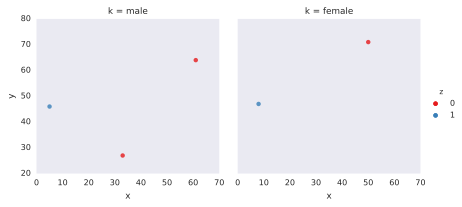

In [3]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

set1 = {'red': '#e41a1c', 'blue': '#377eb8', 'green': '#4daf4a',
        'purple': '#984ea3', 'orange': '#ff7f00', 
        'yellow': '#ffff33', 'brown': '#a65628'}

solarized = dict(yellow='#b58900', orange='#cb4b16', red='#dc322f', 
                 magenta='#d33682', violet='#6c71c4', blue='#268bd2',
                 cyan='#2aa198', green='#859900')

def get_hex_colors(col_map_name, nr_colors):
    hexcolors = list()
    cmap = plt.cm.get_cmap(col_map_name, nr_colors)
    for i in range(cmap.N):
        rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
        hexcolors.append(matplotlib.colors.rgb2hex(rgb))
    return hexcolors

hex_colors = get_hex_colors('Paired', 12)

blue_pair = hex_colors[0:2]
green_pair = hex_colors[2:4]
red_pair = hex_colors[4:6]
orange_pair = hex_colors[6:8]
purple_pair = hex_colors[8:10]
brown_pair = hex_colors[10:12]



import random
df = DataFrame({'x': random.sample(range(1, 100), 5), 
                'y': random.sample(range(1, 100), 5),
                'z': [1,0,0,1,0],
                'k': ['male','male','male','female','female'] })

with sns.color_palette("Set1"):
    with sns.axes_style('dark'): # whitegrid, ticks
        with sns.plotting_context('paper', font_scale=1): # paper, notebook, talk”, poster
            g = sns.lmplot('x', 'y', data=df, hue='z', col='k', fit_reg=False, size=3)

# mpld3.display(ax.fig) # if you want d3

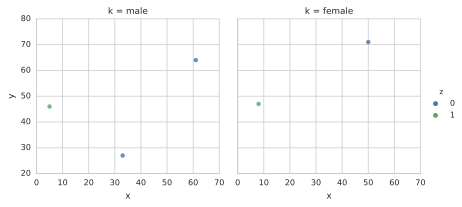

In [4]:
g = sns.lmplot('x', 'y', data=df, hue='z', col='k', fit_reg=False, size=3)

Ignore deprecation warnings from mainly seaborn:

In [5]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

Local code in the scripts dir on the cluster:

In [10]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

from toggle_code_and_errors import toggle_code_html, toggle_errors_html

Import variables global to the entire analysis:

In [11]:
import analysis_globals

In [19]:

df = pandas.read_csv(analysis_globals.meta_data_dir / 'nature18964-s2-fixed-genders.csv', sep=';')
#df = pandas.read_csv(analysis_globals.meta_data_dir / 'nature18964-s2.csv', sep=';')
df.head()

df.loc[df['Genetic sex assignment'] != df['Corrected sex assignmnet (KMT)']]



,nrow,Sequencing Panel,Sample ID (Illumina),Sample ID (Collaborator),Sample ID (SGDP),DNA Source,"Embargo level (X=Fully Public, Y=Signed Letter)",Genetic sex assignment,Corrected sex assignmnet (KMT),Population ID,...,Neanderthal ancestry estimate based on rate of nd10 sites,Denisova ancestry estimate based on rate of nd10 sites,Discordance rate with Human Origins SNP array,Fraction of variants not seen in 1kg at filter level >=1,Fraction of genome covered at 20X,Fraction of genome covered at 10X,Concordance with Omni genotyping array,Contamination estimate (conTEST) at filter level>=0 (fraction),Contamination estimate (conTEST) at filter level>=1 (fraction),Contamination estimate (conTEST) at filter level>=9 (fraction)
146,147,C,LP6005441-DNA_A09,HGDP01344,S_Naxi-2,Genomic_from_cell_lines,X,XY,XX,Naxi,...,"0,025","0,004","0,029","0,0163","0,9","0,92","0,967","0,047","0,048","0,051"
276,277,C,LP6005441-DNA_G09,HGDP00725,S_Palestinian-2,Genomic_from_cell_lines,X,XX,XY,Palestinian,...,"0,017","0,001","0,002","0,0188","0,89","0,91","0,993","0,001","0,001","0,001"


### Analysis dirs

In [9]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
#pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

## Convenience functions

In [15]:
def silent_nanmean(x):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return numpy.nanmean(x)
    
def ident_scalar(s):
    x = s.unique()
    assert(len(x)) == 1
    return x[0]

def flatten_column_index(df):
    df.columns = ['_'.join(col).strip() for col in df.columns.values]


## Load meta data

In [20]:
# easy loading of meta data in a consistent manner across code
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

pop_categories = pandas.read_hdf(str(results_dir / 'population_categories.store'), 'sr')
region_categories = pandas.read_hdf(str(results_dir / 'region_categories.store'), 'sr')
# region_colors = dict(zip(list(region_categories), 
#                          ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', 
#                           '#ff7f00', '#ffff33', '#a65628']))

region_colors = dict(zip(list(region_categories), 
                         ['#e41a1c', '#377eb8',  '#984ea3', '#4daf4a',
                          '#ff7f00', '#ffff33', '#a65628']))

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

In [ ]:
import time
class Timer:    
    def __enter__(self):
        self.start = time.clock()
        return self

    def __exit__(self, *args):
        self.end = time.clock()
        self.interval = self.end - self.start
        print("{:.0f} min {:.1f} sec".format(self.interval//60, self.interval % 60))